# Superconductivity Individual Analysis (New calibration template)

Use this template to carry out the analysis tasks for the experiment.  For reference, here are links to recommended Python resources: the [Whirlwind Tour of Python](https://jakevdp.github.io/WhirlwindTourOfPython/) and the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) both by Jake VanderPlas.

We will be making use of both the [Uncertainties](https://pythonhosted.org/uncertainties/) and [LMFit](https://lmfit.github.io/lmfit-py/) packages in this notebook.

#### Updated to show revised analysis procedures

As of February 2024, use the steps outlined below if you 
* Have taken data with the LabVIEW based Chart Recorder application.
* Wish to use the ITS-90 coefficients to calculate temperature from the pressure data.

In [1]:
# Run this cell with Shift-Enter, and wait until the asterisk changes to a number, i.e., [*] becomes [1]
import numpy as np
import scipy.constants as const
import uncertainties as unc
import uncertainties.unumpy as unp
import uncertainties.umath as um
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 9.0,6.5  # Roughly 9 cm wde by 6.5 cm high
mpl.rcParams['font.size'] = 11.0 # Use 11 point font

## Prior to working on this notebook:

1. Extract the transition points ($I$ through the 5 ohm sensing resistor in voltage units) versus pressure readings ($P$ in voltage units scaled to mmHg, called "torr") from the data scans. Make a CSV spreadsheet file with two columns: "P (torr)", "I (volts)"

2. Calculate the temperature in on of two ways:

    a. Use the "1958 He Scale of Temperatures” booklet, or the [online calculator from Quantum Design](https://qdusa.com/support/helium_vapor_pressure.html).
    
    b. Opt to create a function from the official polynomial fit described in the [International Temperature Scale of 1990 (ITS-90)](https://courses.washington.edu/phys431/superconductivity/ITS-1990_McGlashan_JChemThermo_1990.pdf), to convert the pressure readings to temperature $T$ (K) in the steps below.


### Then...
4. Import the CSV file of pressure/temperature versus transition points in volts across the current-sense resistor into the directory containing this notebook.

5. Create a calibration function to convert measured voltage across the current-sense resistor to magnetic field, using the magnet calibration curve in figure 5 of the (revised in 20204) instructions.

6. Apply the calibration function to obtain the transition points in terms of magnetic field in gauss.

7. Conduct a similar process if using the ITS-90 scale coefficients to obtain the temperature from the pressure reading.  (If you have already done this by hand, skip this step.)

8. Plot $H_c$ vs. $T$.

9. Fit the above using two different methods: (A) linearize the data, then fit to a line and obtain the slope and intercept, and (B) fit to the functional form of equation (1) in the instructions.  From both ways of fitting, find the critical temperature at zero field $T_c$ and the critical field at 0K $H_{c0}$.

10. Obtain the uncertainties in the results from the fits, and compare them to each other and to the values found in a handbook or text.


## Import data tables

Display them so that you know they are correct.

Import $P$ (volts,torr) and/or $T$ (kelvin) and current-sense voltage $I(\text{volts})$

In [3]:
Hg_data = pd.read_csv('superconductivity_data.csv')
Hg_data

,Pressure (Torr),Cursor X (V),Temp (K) (He-4)
0,650.5,0.061524,4.061
1,615.0,0.183333,4.005
2,596.1,0.253333,3.974
3,570.2,0.347143,3.930
4,543.9,0.442857,3.885
5,520.3,0.536000,3.843
6,494.4,0.645238,3.795
7,472.5,0.736000,3.754
8,444.7,0.853810,3.699
9,417.9,0.970000,3.644


Plot the raw data.  Always a good idea to make sure you actually have what you think you have!

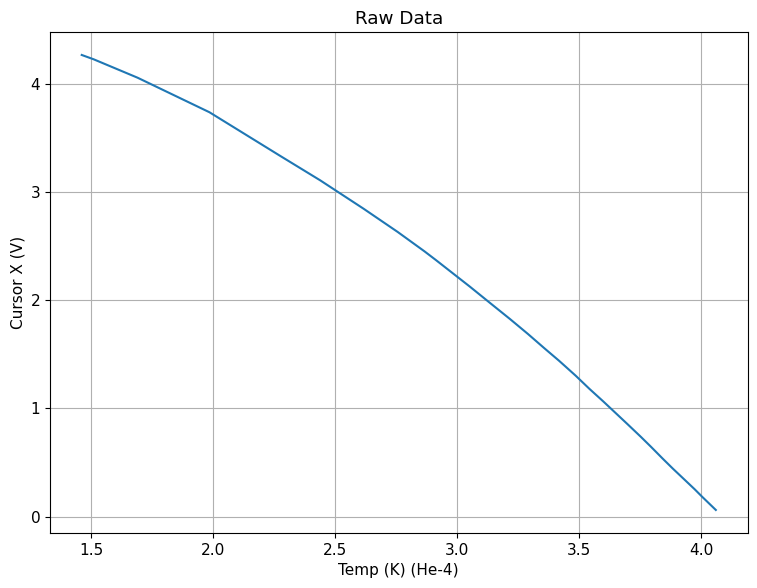

In [4]:
# You code this

plt.plot(Hg_data["Temp (K) (He-4)"], Hg_data["Cursor X (V)"])
plt.title("Raw Data")
plt.xlabel("Temp (K) (He-4)")
plt.ylabel("Cursor X (V)")
plt.grid(True)


## Make a magnet calibration function

Write a function that will convert the transition location in volts to field in gauss.  The Polynomial fit function is shown in the legend of the plot.

**Note:** The data are collected in the direction of **decreasing current** (normal to superconducting transition).

![Magnet calibration data and fit](magnet_cal_2024.png)

In [5]:
## Make your calibration function.

## Then test it

coeffs = [16.9383, 80.8228, 0.4954, -0.1859]

def I2B(I, Cn=coeffs):
    '''
    Magnet calibration functionfor arbitrary polynomial length.
    Assumes that lowest index is constant term.
    '''
    # You code this
    result = np.zeros_like(I)
    
    for i, coeff in enumerate(Cn):
        result += coeff * I**i
    
    return result


Overlay the conversion function on the calibration data.

In [6]:
B = I2B(Hg_data["Cursor X (V)"])

## Apply the magnet calibration

Convert the transition locations to magnetic field.

In [7]:
# Add a column to your data frame.
# See the examples for how one can do this.
Hg_data['Hc (Gauss)'] = B
Hg_data


,Pressure (Torr),Cursor X (V),Temp (K) (He-4),Hc (Gauss)
0,650.5,0.061524,4.061,21.912674
1,615.0,0.183333,4.005,31.771292
2,596.1,0.253333,3.974,37.442154
3,570.2,0.347143,3.930,45.047292
4,543.9,0.442857,3.885,52.812256
5,520.3,0.536000,3.843,60.373020
6,494.4,0.645238,3.795,69.244554
7,472.5,0.736000,3.754,76.618121
8,444.7,0.853810,3.699,86.191049
9,417.9,0.970000,3.644,95.632872


## If using [ITS-90 coefficients](https://courses.washington.edu/phys431/superconductivity/ITS-1990_McGlashan_JChemThermo_1990.pdf), make a temperature function

Skip this step if you already have found the temperature from the online calculator or old look-up table.

Otherwise build a function that converts pressure to temperature from the following formula:

$$T/\text{K} = A_0 + \sum_{i=1}^{8} A_i\left[(\ln(p/\text{Pa})-B)/C\right]^i$$

NOTE: Pressure must be converted from torr to pascals!

The coefficients depend on the pressure.  Helium-4 undergoes a normal to superfluid transition at a particular point called the "lambda" point, which is at 31.81661 torr and 2.1768 K.  The vapor pressure curve varies slightly above and below this point.

| Coefficient |  $p$ $<$ 31.81661 torr | $p$ $\ge$ 31.81661 torr |
|    :---:    |        ---: |       ---: |
|    $A_0$    | 1.392408    | 3.146631   |
|    $A_1$    | 0.527153    | 1.357655   |
|    $A_2$    | 0.166756    | 0.413923   |
|    $A_3$    | 0.050988    | 0.091159   |
|    $A_4$    | 0.026514    | 0.016349   |
|    $A_5$    | 0.001975    | 0.001826   |
|    $A_6$    |-0.017976    |-0.004325   |
|    $A_7$    | 0.005409    |-0.004973   |
|    $A_8$    | 0.013259    | 0          |
|    $B$      | 5.6         | 10.3       |
|    $C$      | 2.9         | 1.9        |

Below, create your function and test it by feeding in a few values of pressure and checking the temerature output against the values obtained by the [online calculator from Quantum Design](https://qdusa.com/support/helium_vapor_pressure.html).

Then apply your function to your array of pressures to obtain the corresponding temperatures.  Don't forget!: your measurements may be in volts, not torr, and the coefficients assume that pressure is in pascals.

**ADVICE** 

Because of the decision that must be made which coefficients to use, it is tricky to make a fuction that will work on a whole NumPy array. But if you use the Uncertainties package version of the math functions, you can make your function propagate the uncertainty in temperature from an uncertainty in the pressure readings. 

SO: Make your function work on single values (possibly with uncertainty), then use the function in a loop to calculate the temperature values, and build an array with these.  (See the example code on GitHub for how to do this.) 

In [8]:
# Build a DataFrame or pair of arrays from the coefficients

# Print them to double-check


In [9]:
# Create the function.  The comments in the function body indicate steps to take.

#def ITS90_p2T(pressure, p_lambda=31.81661, lowP_coeffs=L_coef, hiP_coeffs=H_coef):
    #'''
   # Convert pressure in torr to temperature in Kelvin from the ITS-90 coefficients and formula.
    #This function is NOT NumPy safe, due to the boolean operation needed to choose the coefficients.
    #But it can be used with uncertainty objects.
    #'''
    # Convert lambda point to Pa
    
    # Convert pressure to Pa
    
    # Make a decision which set of coefficients to use, based on whether
    # the pressure is above or below the lambda point.
        
    # Calculate the argument x in the polynomial x = (ln(p) - B)/C
    # if you want to calculate with uncertainties, use unp.log(), othrwise np.log()
    
    # Build a loop to iterate over x
    
    # Return the calculated temperature
  #  return T

Test your pressure to temperature function.  Feed a few pressure values in, and check the results against the [online calculator from Quantum Design](https://qdusa.com/support/helium_vapor_pressure.html)

In [10]:
# Recommended pressures: 760 torr should give typical BP of liquid helium at 4.2K.  
# Lowest pressure of about 3 torr should give near 1.5K.  Check a few points in between as well


### Convert $p$ to $T$

Apply your conversion to the pressure array.  You may need to make a loop to iterate, (unless you know how to deal with boolean operation in NumPy arrays)

In [11]:
# Iterate over the pressure array, and build a new array with np.append()


In [12]:
# Add this to the original dataFrame


## Plot the reduced data set

Plot the data (now in applied field versus temperature, or $H_c$ vs. $T$) so that it mirrors the graph shown in figure 1 of the instructions.  If you see peculiar data points, check for mistakes in transcription or other problems.

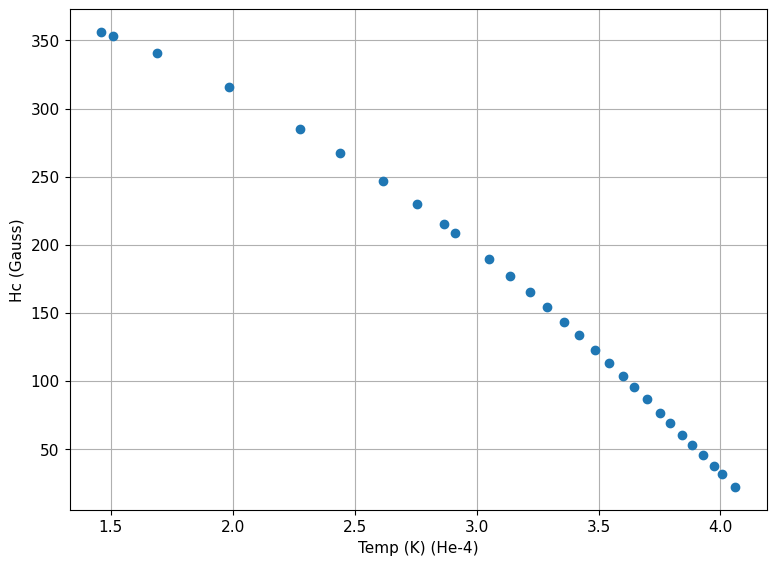

In [13]:
# You code this

plt.plot(Hg_data["Temp (K) (He-4)"], Hg_data["Hc (Gauss)"], 'o')
plt.xlabel("Temp (K) (He-4)")
plt.ylabel("Hc (Gauss)")
plt.grid(True)


## Linearize the data

Rescale the data so that the relationship between the <i>x</i> and <i>y</i> values is linear.  Use equation (1) in the instructions as a guide:

$$H_c(T) = H_{c0}\left[1 - \left(\frac{T}{T_c}\right)^2\right]\quad\quad\quad\quad\quad(1)$$

Then plot the results to confirm.

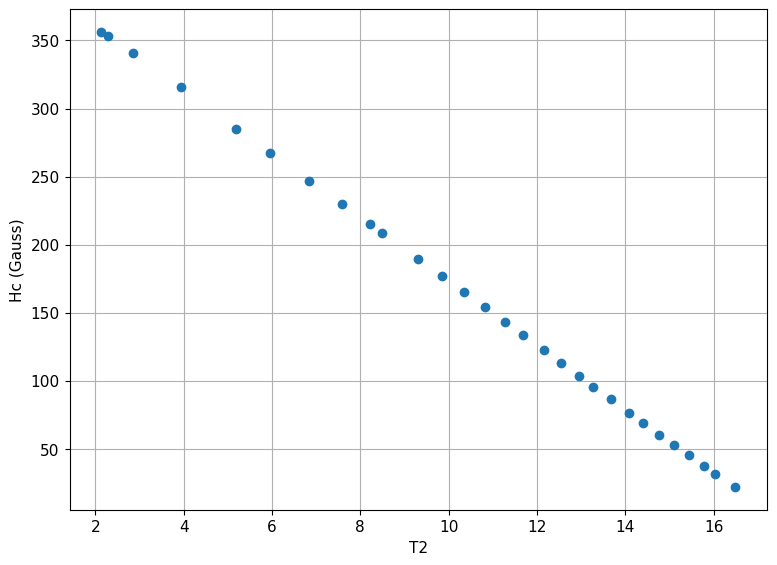

In [14]:
## Take the temperature values and square them
## Example from DataFrame: uT2 = Hg_data['T_90']*Hg_data['T_90']
uT2 = Hg_data['Temp (K) (He-4)'] * Hg_data['Temp (K) (He-4)']
Hc = Hg_data['Hc (Gauss)']
# Then plot the results.  You should see a pretty good straight line.

plt.plot(uT2, Hc, 'o')
plt.title("")
plt.xlabel("T2")
plt.ylabel("Hc (Gauss)")
plt.grid(True)


## Fit the linearized data

Obtain the slope and intercept, plus uncertainty.

In [15]:
from lmfit.models import LinearModel, Model
line = LinearModel()

In [16]:
# You code this
start_params = line.guess(Hc, x = uT2)
Line_fit = line.fit(Hc, start_params, x = uT2)

line_slope = unc.ufloat(Line_fit.params['slope'].value, 
                          Line_fit.params['slope'].stderr)

line_intercept = unc.ufloat(Line_fit.params['intercept'].value, 
                          Line_fit.params['intercept'].stderr)

print('The slope is: {:.2uP} '.format(line_slope))
print('The intercept is: {:.2uP} '.format(line_intercept))

The slope is: -23.416±0.025 
The intercept is: 406.97±0.28 


## Make a nice big, clear plot

Calculate the fit line from eval() and make a large plot, with a grid, data-points with error bars and the fit line on top of the data.  Make sure the fit line goes through both axes so that you can read the critical fiels and critical temperature-squared directly from the plot.

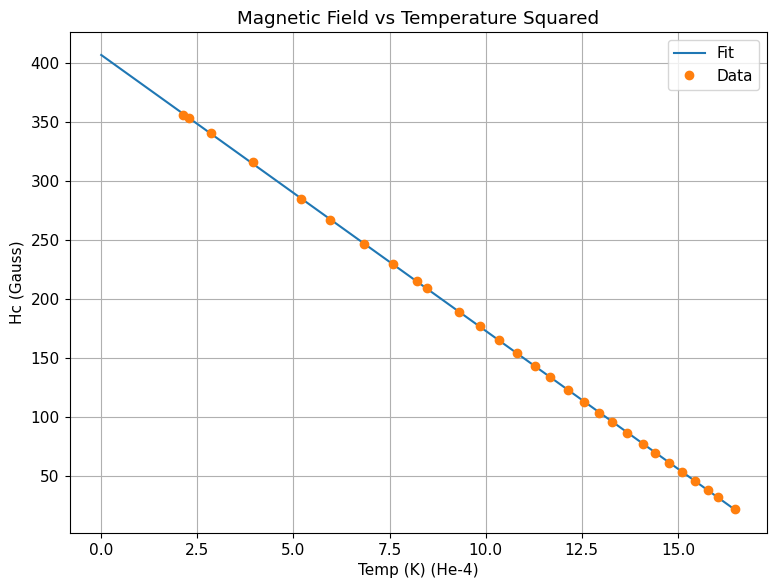

In [17]:
## Make a big plot. Show the fit line going all the way 
uT2_x = np.linspace(0, uT2.max(), 150)
plt.plot(uT2_x, Line_fit.eval(x = uT2_x), label = 'Fit')
plt.plot(uT2, Hc, 'o', label = 'Data')
plt.title("Magnetic Field vs Temperature Squared")
plt.xlabel("Temp (K) (He-4)")
plt.ylabel("Hc (Gauss)")
plt.grid(True)
plt.legend()

## Obtain the critical field and temperature

Calculate $H_{c0}$ and $T_c$ from the fit results (with uncertainty).

In [18]:
# You code this.

Hc0 = line_intercept
Tc = um.sqrt(Hc0/(-1 * line_slope))

#Printing results
print("Critical Field and Temperature")
print('Hc0 = {:.2uP} gauss'.format(Hc0))
print('Tc = {:.2uP} K'.format(Tc))

Critical Field and Temperature
Hc0 = 406.97±0.28 gauss
Tc = 4.1689±0.0026 K


## Fit the "unlinearized" data

Use the LMFit `Model()` class to create a non-linear fit function in the form of equation (1).  Then use it to fit the unlinearized data of $H_c$ vs. $T$ directly.  In this version, the fit parameters should be the values of $H_{c0}$ vs. $T_c$.  

An example of using the `Model()` class to fit an arbitrary function is given in this notebook: [Example of LMFit Model Custom Function](Example%20LMFit%20Model%20with%20Arbitrary%20Function.ipynb) (The notebook should be in your working subdirectory).

In [19]:
# Follow the example for a nonlinear fitting function in the example notebook.

# You will need to define the function correctly, and also provide staring 
# values for the critical tempeature and critical field.

## Define the fit function
def phase_curve(T, Hc0, Tc):
    return Hc0 * (1 - (T/Tc)**2)

## pull in the Model class and set up the fit
curve = Model(phase_curve)

new_fit = curve.fit(Hg_data["Hc (Gauss)"], T = Hg_data['Temp (K) (He-4)'],
                    Hc0 = Hc0.nominal_value, Tc = Tc.nominal_value)

Hc0_nonlin = unc.ufloat(new_fit.params['Hc0'].value, new_fit.params['Hc0'].stderr)
Tc2 = unc.ufloat(new_fit.params['Tc'].value, new_fit.params['Tc'].stderr)

#Printing Information
print(new_fit.fit_report())
print("Nonlinear Fit Values:")
print('Hc0 = {:.2uP} gauss'.format(Hc0_nonlin))
print('Tc = {:.2uP} K'.format(Tc2))

## Fit and plot
T_eval = np.linspace(0, Hg_data['Temp (K) (He-4)'].max() + 0.2, 100)
init_fit = new_fit.model.eval(params = new_fit.init_params, T = T_eval)
best_fit = new_fit.model.eval(params = new_fit.params, T = T_eval)


[[Model]]
    Model(phase_curve)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 29
    # variables        = 2
    chi-square         = 8.82382195
    reduced chi-square = 0.32680822
    Akaike info crit   = -30.5053811
    Bayesian info crit = -27.7707894
    R-squared          = 0.99997023
[[Variables]]
    Hc0:  406.966641 +/- 0.27836084 (0.07%) (init = 406.9666)
    Tc:   4.16889972 +/- 0.00102660 (0.02%) (init = 4.1689)
[[Correlations]] (unreported correlations are < 0.100)
    C(Hc0, Tc) = -0.5821
Nonlinear Fit Values:
Hc0 = 406.97±0.28 gauss
Tc = 4.1689±0.0010 K


## Make another big, clear plot

Make a nice plot for this type of fit, similar to what you did above, showing the fit line intersecting both axes.

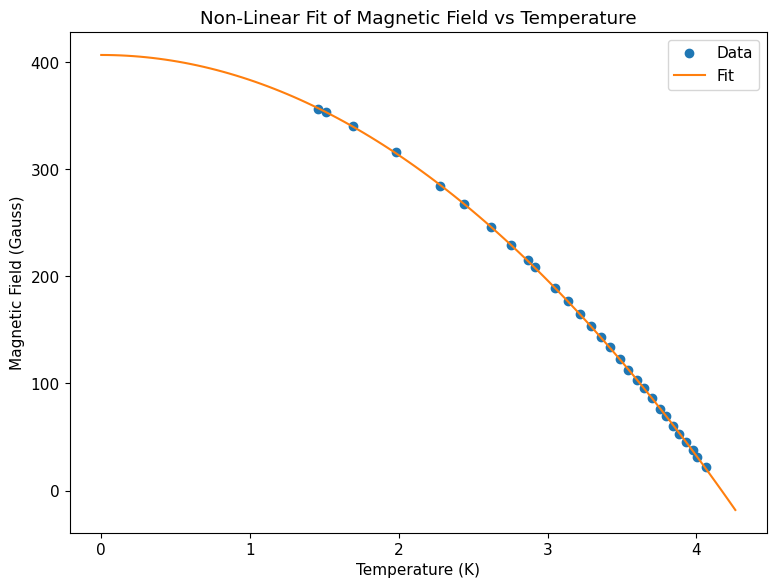

In [20]:
## Make a big plot
plt.plot(Hg_data['Temp (K) (He-4)'], Hg_data['Hc (Gauss)'], 'o', label = 'Data')
plt.plot(T_eval, best_fit, '-', label = 'Fit')
plt.title('Non-Linear Fit of Magnetic Field vs Temperature') 
plt.xlabel('Temperature (K)')
plt.ylabel('Magnetic Field (Gauss)')
plt.legend()


## Compare the fit results

Compare the fit results from both procedures to each other: do they agree within their uncertainty?  Do the fit results agree with handbook or text values?  Print the all in a single table for easy comparison.

In [21]:
# Table
print('Comparison of fit results:')
print('   Tc (K)   |   Hc0 (G)   ')
print('------------|-------------')
print('{:.2uP} | {:.2uP}     (from linearized data)'.format(Tc,Hc0))
print('{:.1uP} | {:.2uP}       (from nonlinear fit)'.format(Tc2,Hc0_nonlin))
print('{:8.2f}    | {:.1f}             (handbook)'.format(4.15,410.0))

Comparison of fit results:
   Tc (K)   |   Hc0 (G)   
------------|-------------
4.1689±0.0026 | 406.97±0.28     (from linearized data)
4.169±0.001 | 406.97±0.28       (from nonlinear fit)
    4.15    | 410.0             (handbook)
